<a href="https://colab.research.google.com/github/singhbishtabhishek/Image-Captioning-using-a-dataset-/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#mount drive and import necessary modules after installing

from google.colab import drive
drive.mount('/content/drive')
import os
import string
import numpy as np
import pickle
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
tqdm().pandas()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0it [00:00, ?it/s]


In [5]:
#setting the path of the dataset to use.

project_dir = '/content/drive/MyDrive/ImageCaptioning'
dataset_text = os.path.join(project_dir, 'Flickr8k_text')
dataset_images = os.path.join(project_dir, 'Flicker8k_Dataset')
os.makedirs(project_dir, exist_ok=True)


In [6]:
#cleaning texts and reading the captions files

def load_doc(filename):
    with open(filename, 'r') as file:
        return file.read()

def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.strip().split('\n')
    descriptions = {}
    for line in captions:
        tokens = line.split('\t')
        if len(tokens) != 2:
            continue
        img_id, caption = tokens
        img_id = img_id.split('#')[0]
        if img_id not in descriptions:
            descriptions[img_id] = []
        descriptions[img_id].append(caption)
    return descriptions

def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i in range(len(caps)):
            desc = caps[i].lower().replace("-", " ").split()
            desc = [w.translate(table) for w in desc if len(w) > 1 and w.isalpha()]
            caps[i] = ' '.join(desc)
    return captions

def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions:
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(f"{key}\t{desc}")
    with open(filename, "w") as file:
        file.write("\n".join(lines))

caption_file = os.path.join(dataset_text, "Flickr8k.token.txt")
descriptions = all_img_captions(caption_file)
print(f"Loaded {len(descriptions)} images with captions")

clean_descriptions = cleaning_text(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print(f"Vocabulary size: {len(vocabulary)}")

desc_path = os.path.join(project_dir, "descriptions.txt")
save_descriptions(clean_descriptions, desc_path)
print("Cleaned descriptions saved")

print("Loading Xception model for feature extraction...")
model_cnn = Xception(include_top=False, pooling='avg', weights='imagenet')


Loaded 8092 images with captions
Vocabulary size: 8412
Cleaned descriptions saved
Loading Xception model for feature extraction...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
#Extracting features , matching the photos and descriptions file

def extract_features(directory):
    features = {}
    for img in tqdm(os.listdir(directory), desc="Extracting features"):
        if not img.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(directory, img)
        try:
            image = Image.open(path).resize((299, 299)).convert('RGB')
            image = np.expand_dims(np.array(image), axis=0)
            image = preprocess_input(image)
            feature = model_cnn.predict(image, verbose=0)
            features[img] = feature[0]
        except Exception as e:
            print(f"Error processing {img}: {e}")
    return features

features_path = os.path.join(project_dir, "features.p")
if os.path.exists(features_path):
    print("Loading existing features...")
    with open(features_path, "rb") as f:
        features = pickle.load(f)
else:
    print("Extracting features from images...")
    features = extract_features(dataset_images)
    with open(features_path, "wb") as f:
        pickle.dump(features, f)
print(f"Extracted features for {len(features)} images")

def load_photos(filename):
    file = load_doc(filename)
    return [line.strip() for line in file.strip().split("\n")]

def load_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.strip().split("\n"):
        tokens = line.split('\t')
        if len(tokens) < 2:
            continue
        image, caption = tokens[0], tokens[1]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = "startseq " + caption + " endseq"
            descriptions[image].append(desc)
    return descriptions

def load_features(filename, photos):
    all_features = pickle.load(open(filename, "rb"))
    return {k: all_features[k] for k in photos if k in all_features}

train_img_file = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")
train_imgs = load_photos(train_img_file)
train_descriptions = load_descriptions(desc_path, train_imgs)
train_features = load_features(features_path, train_imgs)
print(f"Training data: {len(train_descriptions)} images, {len(train_features)} features")


Loading existing features...
Extracted features for 8092 images
Training data: 6000 images, 6000 features


In [8]:
val_img_file = os.path.join(dataset_text, "Flickr_8k.devImages.txt")
val_imgs = load_photos(val_img_file)
val_descriptions = load_descriptions(desc_path, val_imgs)
val_features = load_features(features_path, val_imgs)
print(f"Validation data: {len(val_descriptions)} images, {len(val_features)} features")

Validation data: 1000 images, 1000 features


In [9]:
def dict_to_list(descriptions):
    return [desc for descs in descriptions.values() for desc in descs]

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer_path = os.path.join(project_dir, "tokenizer.p")
if os.path.exists(tokenizer_path):
    print("Loading existing tokenizer...")
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
else:
    print("Creating tokenizer...")
    tokenizer = create_tokenizer(train_descriptions)
    with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

vocab_size = len(tokenizer.word_index) + 1

def max_length(descriptions):
    return max(len(d.split()) for d in dict_to_list(descriptions))

max_len = max_length(train_descriptions)
print(f"Maximum caption length: {max_len}")
print(f"Vocabulary size: {vocab_size}")


Loading existing tokenizer...
Maximum caption length: 35
Vocabulary size: 7311


In [10]:
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [24]:
def data_generator(descriptions, features, tokenizer, max_length, batch_size=32):
    keys = list(descriptions.keys())
    while True:
        np.random.shuffle(keys)
        for i in range(0, len(keys), batch_size):
            batch_keys = keys[i:i+batch_size]
            X1, X2, y = [], [], []
            for key in batch_keys:
                if key in features:
                    photo = features[key]
                    desc_list = descriptions[key]
                    in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
                    X1.extend(in_img)
                    X2.extend(in_seq)
                    y.extend(out_word)

            if len(X1) > 0:
                X1_arr = np.array(X1, dtype=np.float32)
                X2_arr = np.array(X2, dtype=np.int32)
                y_arr = np.array(y, dtype=np.float32)

            yield (X1_arr, X2_arr), y_arr


In [13]:
def define_model(vocab_size, max_length):

    inputs1 = Input(shape=(2048,), name='image_features')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,), name='text_input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

model = define_model(vocab_size, max_len)
model.summary()

print(f"Model type: {type(model)}")
print(f"Model has fit method: {hasattr(model, 'fit')}")

save_path = os.path.join(project_dir, "models")
os.makedirs(save_path, exist_ok=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_features            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 35, 256)        │      1,871,616 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 35, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 35)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 7311)           │      1,878,927 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,866,191 (18.56 MB)

 Trainable params: 4,866,191 (18.56 MB)

 Non-trainable params: 0 (0.00 B)

Model type: <class 'keras.src.models.functional.Functional'>
Model has fit method: True


In [22]:
#Traning the model

EPOCHS = 10
BATCH_SIZE = 32

steps_per_epoch = max(1, len(train_descriptions) // BATCH_SIZE)
validation_steps = max(1, len(val_descriptions) // BATCH_SIZE)

print(f"Training samples: {len(train_descriptions)}")
print(f"Validation samples: {len(val_descriptions)}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Batch size: {BATCH_SIZE}")

train_generator = data_generator(train_descriptions, train_features, tokenizer, max_len, BATCH_SIZE)
val_generator = data_generator(val_descriptions, val_features, tokenizer, max_len, BATCH_SIZE)

checkpoint_path = os.path.join(project_dir, "model_checkpoint.keras")
callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Starting training...")
try:
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    final_model_path = os.path.join(project_dir, "model_final.keras")
    model.save(final_model_path)
    print(f"Model saved to {final_model_path}")

except Exception as e:
    print(f"Training error: {e}")
    print("Trying to save current model state...")
    model.save(os.path.join(project_dir, "model_error_state.keras"))

def extract_feature_img(image_path):
    """Extract features from a single image"""
    image = Image.open(image_path).resize((299, 299)).convert('RGB')
    image = np.expand_dims(np.array(image), axis=0)
    image = preprocess_input(image)
    feature = model_cnn.predict(image, verbose=0)
    return feature

def generate_caption(model, tokenizer, photo, max_length):
    """Generate caption for an image"""
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        photo = np.expand_dims(photo, axis=0)
        sequence = pad_sequences([sequence], maxlen=max_length,padding='post')
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        if word == 'endseq':
            break
        in_text += ' ' + word
    final = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final

print("\nTraining completed!")
print(f"Final model saved to: {os.path.join(project_dir, 'model_final.keras')}")
print(f"Tokenizer saved to: {tokenizer_path}")
print(f"Features saved to: {features_path}")

Training samples: 6000
Validation samples: 1000
Steps per epoch: 187
Validation steps: 31
Batch size: 32
Starting training...
Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.4778 - loss: 2.0162
Epoch 1: val_loss improved from inf to 3.87838, saving model to /content/drive/MyDrive/ImageCaptioning/model_checkpoint.keras
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.4778 - loss: 2.0164 - val_accuracy: 0.3283 - val_loss: 3.8784
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4806 - loss: 1.9898
Epoch 2: val_loss did not improve from 3.87838
187/187 ━━━━━━━━━━━━━━━━━━━━ 43s 233ms/step - accuracy: 0.4806 - loss: 1.9900 - val_accuracy: 0.3277 - val_loss: 3.9320
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.4857 - loss: 1.9691
Epoch 3: val_loss did not improve from 3.87838
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.4857 - loss: 1.9693 - val_accuracy: 0.3257 - val_loss: 3.9696
Epoch 4/10
187/187 ━━━━━━━━━━━

Model and tokenizer loaded
Please upload an image...


Saving Testing_Image.jpg to Testing_Image.jpg


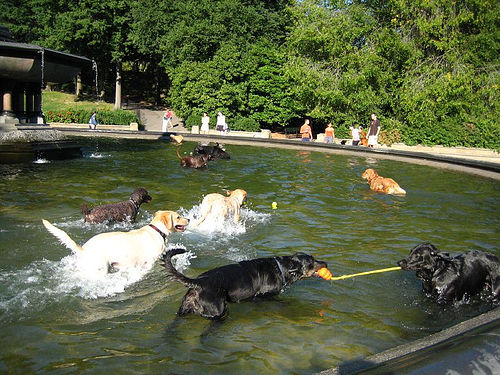

Generated Caption: several dogs swimming in pool


In [23]:
#Testing on a given image

from PIL import Image
from google.colab import files
from IPython.display import display
project_dir = '/content/drive/MyDrive/ImageCaptioning'
model_path = os.path.join(project_dir, 'model_final.keras')
tokenizer_path = os.path.join(project_dir, 'tokenizer.p')
max_len = 35

with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

model = load_model(model_path)
print("Model and tokenizer loaded")

xception_model = Xception(include_top=False, pooling='avg')

def extract_feature_img(image_path):
    """Extract Xception features from a single image"""
    image = Image.open(image_path).resize((299, 299)).convert('RGB')
    image = np.expand_dims(np.array(image), axis=0)
    image = preprocess_input(image)
    feature = xception_model.predict(image, verbose=0)
    return feature

def generate_caption(model, tokenizer, photo, max_length):
    """Generate a caption for the given photo features"""
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length,padding='post')
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()

print("Please upload an image...")
uploaded = files.upload()

for filename in uploaded.keys():
    display(Image.open(filename))
    photo = extract_feature_img(filename)
    caption = generate_caption(model, tokenizer, photo, max_len)
    print(f"Generated Caption: {caption}")